# learn-embeddings

> This notebook contains the code for learning embeddings at various stages of the pipeline.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from collections import defaultdict
from functools import partial
import gc
from operator import itemgetter
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Protocol, Sequence, Tuple, TypeVar, Type

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import tempfile
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.training_utils import CheckPointer, GetBatchFunction, Trainer
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
    batch_cosine_sim,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
    pre_filter_cosine_sim_results,
)
from transformer_experiments.experiments.final_ffwd import FinalFFWDExperiment
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is paperspace


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cuda


## Core Idea

At any point in the transformer after tokens have been embedded, we can think of the remainder of the pipeline as a function that transforms from embedding space ($\mathbb{R}^{384}$ since `n_embed = 384`) to logit space ($\mathbb{R}^{65}$  `vocab_size=65`). For a given token, say the letter `a`, we might ask: at this point in the pipeline, what embedding will produce output logits that result in a probability very close to 1 for this token? In other words, what embedding, if provided as input at this point, will result in the transformer predicting the given token as the next token? 

I suspect this is difficult to determine analytically, especially for earlier parts of the pipeline where the input embedding has to go through many transformer blocks before output logits are computed. But, we can actually *learn* the embeddings that result in the right kind of logits. 

I say embeddings - plural - because it seems there isn't just one unique embedding for each token. Likely, there is some subspace of the full embeddings space, $\mathbb{R}^{384}$, that corresponds to specific tokens being predicted. While I don't know of a way to find the bounds of this space directly, we can learn several embeddings within the space and then work out a good enough approximation of the space. 

To do this, we set up a typical deep-learning problem:
* The portion of the transformer we're interested in is fixed; the embeddings input into it are the parameters we're optimizing and they start with random initialization. 
* We do a forward pass, computing the logits from the embeddings we have.
* We compute negative log likelihood loss relative to the token we're trying to learn embeddings for. 
* We do a backward pass, adjusting the values of the embeddings according to the gradients.

It works remarkably well.


In [ ]:
def learn_embedding_for_char(
    target_char: str,
    embedding_to_logits: Callable[[torch.Tensor], torch.Tensor],
    n_embeddings_to_learn: int = 1,
    learning_rate: float = 3e-4,
    minimum_loss: float = 1e-4,
    max_iters: int = 50000,
    device: str = device,
) -> torch.Tensor:
    """Given a character, learns the embedding that,
    when given as input to the `embedding_to_logits`
    function, produces the logits select that character
    with probability almost 1."""
    assert len(target_char) == 1
    target = torch.tensor(tokenizer.encode(target_char), device=device)

    lsfm = nn.LogSoftmax(dim=-1)
    lsfm.to(device)

    x = torch.nn.Parameter(
        torch.randn(n_embeddings_to_learn, 1, n_embed, device=device),
        requires_grad=True,
    )

    optimizer = torch.optim.AdamW([x], lr=learning_rate)
    eval_iters = max_iters // 10

    print(f"Optimizing embedding for {repr(target_char)}")
    for step in range(max_iters):
        logits = embedding_to_logits(x)
        B, T, C = logits.shape

        yhat = lsfm(logits.view(B * T, C))
        loss = F.nll_loss(yhat, target.expand(n_embeddings_to_learn))

        if loss < minimum_loss:
            print(f"ending training at step {step:>5}: loss {loss.item():.6f}")
            break

        if step % eval_iters == 0:
            print(f"step {step:>5}: loss {loss.item():.6f}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return x.data.detach(), loss

Define a function that encapsulate the final output head of the transformer, after all the blocks (basically, a layer norm followed by a linear layer going from embedding space to token space):

In [ ]:
def transformer_output_head_function(m: TransformerLanguageModel) -> Callable[[torch.Tensor], torch.Tensor]:
    ln_f = nn.LayerNorm(n_embed)
    lm_head = nn.Linear(n_embed, tokenizer.vocab_size)

    ln_f.load_state_dict(m.ln_f.state_dict())
    lm_head.load_state_dict(m.lm_head.state_dict())

    ln_f.to(device)
    lm_head.to(device)

    return lambda x: lm_head(ln_f(x))


Now we can use this to learn, e.g., an embedding that, at the very end of the transformer, after all the blocks, is likely to produce a next token probability for `a` of nearly 1. 

In [ ]:
torch.manual_seed(42)
emb_a, _ = learn_embedding_for_char('a', transformer_output_head_function(m))

Optimizing embedding for 'a'
step     0: loss 2.809722
step  5000: loss 0.009828
step 10000: loss 0.000751
ending training at step 14316: loss 0.000100


We can test this, by sending the resulting embedding through the output head and plotting the next token probabilities:

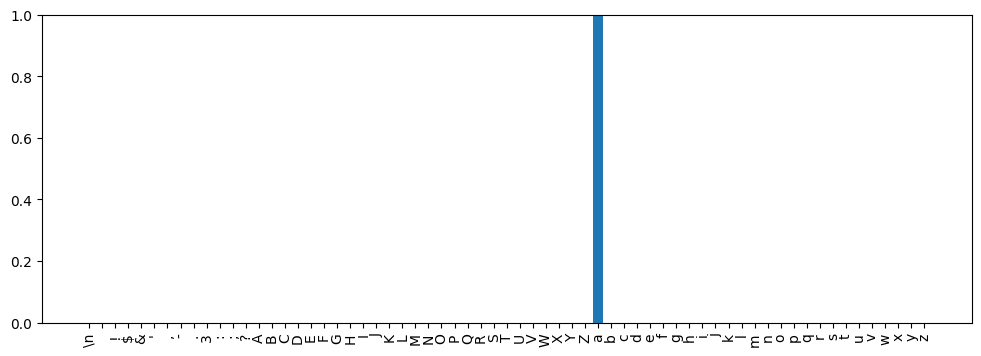

In [ ]:
logits = LogitsWrapper(accessors.logits_from_embedding(unsqueeze_emb(emb_a)), tokenizer)
logits.plot_probs()

That was just one possible embedding that selects `a`. We can learn others. The following code snippet will learn 100 such embeddings.

In [ ]:
# Try learning more than one embedding

torch.manual_seed(42)
multi_emb_a, _ = learn_embedding_for_char(
    "a", transformer_output_head_function(m), n_embeddings_to_learn=100
)

Optimizing embedding for 'a'
step     0: loss 4.480039
step  5000: loss 0.014915
step 10000: loss 0.001181
step 15000: loss 0.000119
ending training at step 15389: loss 0.000100


In [ ]:
multi_emb_a.shape

torch.Size([100, 1, 384])

We can convince ourselves that these are sufficiently varied by examining some stats:

In [ ]:
def multi_emb_stats(multi_embs: torch.Tensor):
    norms = torch.norm(multi_embs[:, 0, :], dim=-1)
    print(f"norms: mean {norms.mean().item():.6f}, std {norms.std().item():.6f}")
    print(f"norms: min {norms.min().item():.6f}, max {norms.max().item():.6f}")

    norm_diffs = []
    for i in range(multi_embs.shape[0]):
        for j in range(multi_embs.shape[0]):
            if i != j:
                norm_diffs.append(torch.norm(multi_embs[i, 0, :] - multi_embs[j, 0, :]))

    norm_diffs = torch.tensor(norm_diffs)
    print(f"norm diffs: mean {norm_diffs.mean().item():.6f}, std {norm_diffs.std().item():.6f}")
    print(f"norm diffs: min {norm_diffs.min().item():.6f}, max {norm_diffs.max().item():.6f}")

In [ ]:
multi_emb_stats(multi_emb_a)

norms: mean 16.764254, std 0.759987
norms: min 15.078418, max 18.306231
norm diffs: mean 16.599855, std 0.760862
norm diffs: min 13.795146, max 19.167126


The norms of the embeddings range from about 15 to about 18, with a mean of about 16.7. Then if we compute the differences between all the learned embeddings and take the norms of those differences, we see that they are quite large: the differences range from 13.8 to about 19, with a mean of 16.6. If we'd somehow learned 100 nearly identical vectors, the differences would be a lot smaller. 

Now we'll define a function that implements the portion of a the transformer pipeline from a given block onwards. E.g. If called with `n=3`, this would implement blocks index 3, 4, and 5, plus the transformer output head. 

In [ ]:
def block_n_on_function(m: TransformerLanguageModel, n: int) -> Callable[[torch.Tensor], torch.Tensor]:
    assert n >= 0 and n < n_layer, "n must be in [0, n_layer)"

    blocks, _ = zip(
        *[
            accessors.copy_block_from_model(block_idx=i)
            for i in range(n, n_layer)
        ]
    )
    blocks_module = torch.nn.Sequential(*blocks)
    output_head = transformer_output_head_function(m)
    return lambda x: output_head(blocks_module(x))

We can now learn 100 embeddings for the letter a, from block index 5 (the last block) in transformer.

In [ ]:
torch.manual_seed(42)
multi_emb_a_5, _ = learn_embedding_for_char('a', block_n_on_function(m, n=5), n_embeddings_to_learn=100)

Optimizing embedding for 'a'
step     0: loss 4.540399
step  5000: loss 0.003825
step 10000: loss 0.000321
ending training at step 12689: loss 0.000100


In [ ]:
multi_emb_stats(multi_emb_a_5)

norms: mean 17.498230, std 0.640826
norms: min 15.787105, max 19.508923
norm diffs: mean 23.514679, std 0.885002
norm diffs: min 20.520039, max 27.281914


These show even more variation than the ones learned for the output head alone. 

As a spot check, let's plot an arbitrary one of these:

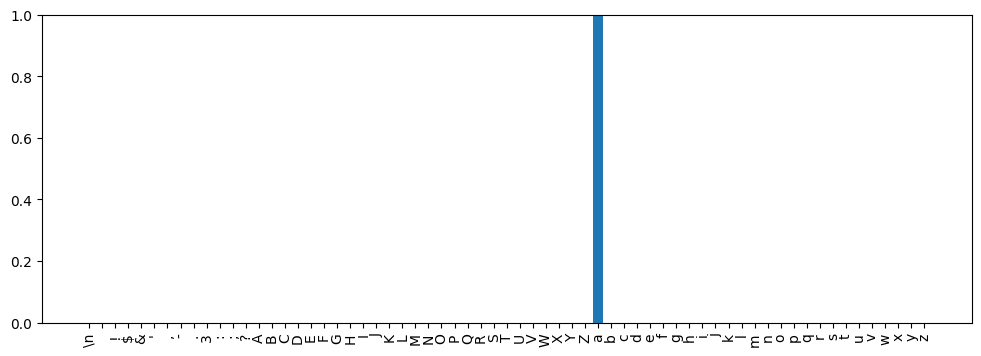

In [ ]:
# Try an arbitrary embedding and plot it.
logits = LogitsWrapper(block_n_on_function(m, n=5)(unsqueeze_emb(multi_emb_a_5[22, 0, :])).detach(), tokenizer)
logits.plot_probs()

It produces `a` with probability nearly 1, as we'd expect. I spot checked with several more examples and they all looked right. 

Next, we can learn embeddings from an earlier point, say from block index 1 on:

In [ ]:
torch.manual_seed(42)
multi_emb_a_1, _ = learn_embedding_for_char('a', block_n_on_function(m, n=1), n_embeddings_to_learn=100)

Optimizing embedding for 'a'
step     0: loss 3.682070
step  5000: loss 0.003850
step 10000: loss 0.000303
ending training at step 12545: loss 0.000100


In [ ]:
multi_emb_stats(multi_emb_a_1)

norms: mean 17.507275, std 0.661216
norms: min 15.955662, max 18.931648
norm diffs: mean 24.441858, std 0.949635
norm diffs: min 21.217833, max 27.614788


Even more variation now. Again, let's spot check:

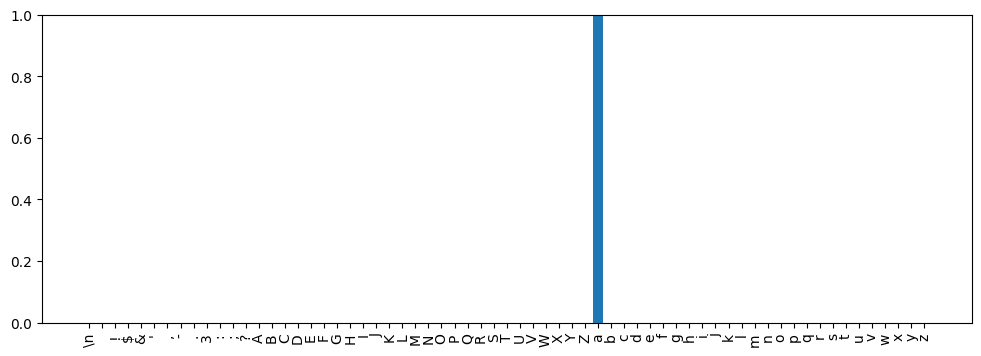

In [ ]:
# Try an arbitrary embedding and plot it.
logits = LogitsWrapper(block_n_on_function(m, n=1)(unsqueeze_emb(multi_emb_a_1[63, 0, :])).detach(), tokenizer)
logits.plot_probs()

With this in place, we can now learn embeddings for all the tokens and save them for later use.

## Learn embeddings for each token and save them

In [ ]:
results_folder = environment.data_root / 'learned_embeddings'
results_folder.mkdir(exist_ok=True)

In [ ]:
filename_for_token = FilenameForToken(tokenizer)

In [ ]:
n_embeddings_to_learn = 100

### No Blocks

Learn embeddings for just the output head:

In [ ]:
embedding_to_logits_function = transformer_output_head_function(m)
sub_dir = results_folder / f'no_blocks'
sub_dir.mkdir(exist_ok=True)

In [ ]:
for target_char in tqdm(tokenizer.chars):
    multi_embs, _ = learn_embedding_for_char(
        target_char, embedding_to_logits_function, n_embeddings_to_learn=n_embeddings_to_learn
    )
    torch.save(multi_embs, sub_dir / f'{filename_for_token(target_char)}.pt')

  0%|          | 0/65 [00:00<?, ?it/s]

Optimizing embedding for '\n'
step     0: loss 4.873875
step  5000: loss 0.014350
step 10000: loss 0.001145
step 15000: loss 0.000115
ending training at step 15317: loss 0.000100
Optimizing embedding for ' '
step     0: loss 4.264826
step  5000: loss 0.016041
step 10000: loss 0.001354
step 15000: loss 0.000146
ending training at step 15895: loss 0.000100
Optimizing embedding for '!'
step     0: loss 4.792295
step  5000: loss 0.012945
step 10000: loss 0.000995
ending training at step 14904: loss 0.000100
Optimizing embedding for '$'
step     0: loss 5.333682
step  5000: loss 0.057611
step 10000: loss 0.005992
step 15000: loss 0.001061
step 20000: loss 0.000405
step 25000: loss 0.000354
step 30000: loss 0.000354
step 35000: loss 0.000354
step 40000: loss 0.000354
step 45000: loss 0.000354
Optimizing embedding for '&'
step     0: loss 5.297050
step  5000: loss 0.059776
step 10000: loss 0.006204
step 15000: loss 0.001161
step 20000: loss 0.000509
step 25000: loss 0.000470
step 30000: loss 

### 1 Block

Learn embeddings from the last block (block index 5 onwards):

In [ ]:
block_n_on = 5
embedding_to_logits_function = block_n_on_function(m, n=block_n_on)
sub_dir = results_folder / f'block_{block_n_on}'
sub_dir.mkdir(exist_ok=True)

In [ ]:
for target_char in tqdm(tokenizer.chars):
    multi_embs, _ = learn_embedding_for_char(
        target_char, embedding_to_logits_function, n_embeddings_to_learn=n_embeddings_to_learn
    )
    torch.save(multi_embs, sub_dir / f'{filename_for_token(target_char)}.pt')

  0%|          | 0/65 [00:00<?, ?it/s]

Optimizing embedding for '\n'
step     0: loss 5.347430
step  5000: loss 0.007386
step 10000: loss 0.000657
ending training at step 14478: loss 0.000100
Optimizing embedding for ' '
step     0: loss 3.744530
step  5000: loss 0.005794
step 10000: loss 0.000533
ending training at step 14041: loss 0.000100
Optimizing embedding for '!'
step     0: loss 6.476709
step  5000: loss 0.007308
step 10000: loss 0.000641
ending training at step 14254: loss 0.000100
Optimizing embedding for '$'
step     0: loss 8.133106
step  5000: loss 0.085841
step 10000: loss 0.009670
step 15000: loss 0.001712
step 20000: loss 0.000555
step 25000: loss 0.000398
step 30000: loss 0.000378
step 35000: loss 0.000371
step 40000: loss 0.000367
step 45000: loss 0.000365
Optimizing embedding for '&'
step     0: loss 7.565117
step  5000: loss 0.093037
step 10000: loss 0.010646
step 15000: loss 0.002142
step 20000: loss 0.000802
step 25000: loss 0.000548
step 30000: loss 0.000499
step 35000: loss 0.000487
step 40000: loss 

#### With 1000 embeddings per token
I wanted to see if we got better results with more embeddings, so let's learn 1000 embeddings / token for the last block.

In [ ]:
block_n_on = 5
n_embeddings_to_learn=1000
embedding_to_logits_function = block_n_on_function(m, n=block_n_on)
sub_dir = results_folder / f'block_{block_n_on}_{n_embeddings_to_learn}'
sub_dir.mkdir(exist_ok=True)

In [ ]:
for target_char in tqdm(tokenizer.chars):
    multi_embs, _ = learn_embedding_for_char(
        target_char, embedding_to_logits_function, n_embeddings_to_learn=n_embeddings_to_learn
    )
    torch.save(multi_embs, sub_dir / f'{filename_for_token(target_char)}.pt')

  0%|          | 0/13 [00:00<?, ?it/s]

Optimizing embedding for 'n'
step     0: loss 4.559832
step  5000: loss 0.004011
step 10000: loss 0.000314
ending training at step 12531: loss 0.000100
Optimizing embedding for 'o'
step     0: loss 4.772153
step  5000: loss 0.005388
step 10000: loss 0.000453
ending training at step 13553: loss 0.000100
Optimizing embedding for 'p'
step     0: loss 5.451766
step  5000: loss 0.004887
step 10000: loss 0.000375
ending training at step 12905: loss 0.000100
Optimizing embedding for 'q'
step     0: loss 6.712268
step  5000: loss 0.009738
step 10000: loss 0.000777
ending training at step 14641: loss 0.000100
Optimizing embedding for 'r'
step     0: loss 4.504239
step  5000: loss 0.003917
step 10000: loss 0.000304
ending training at step 12451: loss 0.000100
Optimizing embedding for 's'
step     0: loss 3.967334
step  5000: loss 0.004284
step 10000: loss 0.000346
ending training at step 12817: loss 0.000100
Optimizing embedding for 't'
step     0: loss 4.246644
step  5000: loss 0.003862
step 10

#### With 5000 embeddings per token


Let's see if even more embeddings help: learn 5000 embeddings/token.

In [ ]:
block_n_on = 5
n_embeddings_to_learn=5000
embedding_to_logits_function = block_n_on_function(m, n=block_n_on)
sub_dir = results_folder / f'block_{block_n_on}_{n_embeddings_to_learn}'
sub_dir.mkdir(exist_ok=True)
print(sub_dir)

/storage/learned_embeddings/block_5_5000


In [ ]:
for target_char in tqdm(tokenizer.chars):
    multi_embs, _ = learn_embedding_for_char(
        target_char, embedding_to_logits_function, n_embeddings_to_learn=n_embeddings_to_learn
    )
    torch.save(multi_embs, sub_dir / f'{filename_for_token(target_char)}.pt')

  0%|          | 0/65 [00:00<?, ?it/s]

Optimizing embedding for '\n'
step     0: loss 5.594407
step  5000: loss 0.007269
step 10000: loss 0.000696
step 15000: loss 0.000120
ending training at step 15687: loss 0.000100
Optimizing embedding for ' '
step     0: loss 3.438382
step  5000: loss 0.005430
step 10000: loss 0.000537
step 15000: loss 0.000103
ending training at step 15140: loss 0.000100
Optimizing embedding for '!'
step     0: loss 6.517096
step  5000: loss 0.007284
step 10000: loss 0.000668
step 15000: loss 0.000103
ending training at step 15083: loss 0.000100
Optimizing embedding for '$'
step     0: loss 7.965337
step  5000: loss 0.082970
step 10000: loss 0.009700
step 15000: loss 0.001987
step 20000: loss 0.000854
step 25000: loss 0.000615
step 30000: loss 0.000530
step 35000: loss 0.000489
step 40000: loss 0.000464
step 45000: loss 0.000448
Optimizing embedding for '&'
step     0: loss 7.658935
step  5000: loss 0.095831
step 10000: loss 0.011111
step 15000: loss 0.002514
step 20000: loss 0.001186
step 25000: loss 

### 2 Blocks


Learn embeddings for last 2 blocks:

In [ ]:
block_n_on = 4
embedding_to_logits_function = block_n_on_function(m, n=block_n_on)
sub_dir = results_folder / f'block_{block_n_on}'
sub_dir.mkdir(exist_ok=True)

In [ ]:
for target_char in tqdm(tokenizer.chars):
    multi_embs, _ = learn_embedding_for_char(
        target_char, embedding_to_logits_function, n_embeddings_to_learn=n_embeddings_to_learn
    )
    torch.save(multi_embs, sub_dir / f'{filename_for_token(target_char)}.pt')

  0%|          | 0/65 [00:00<?, ?it/s]

Optimizing embedding for '\n'
step     0: loss 5.976839
step  5000: loss 0.008648
step 10000: loss 0.000779
ending training at step 14971: loss 0.000100
Optimizing embedding for ' '
step     0: loss 3.259852
step  5000: loss 0.005781
step 10000: loss 0.000530
ending training at step 14046: loss 0.000100
Optimizing embedding for '!'
step     0: loss 6.406515
step  5000: loss 0.006404
step 10000: loss 0.000584
ending training at step 14109: loss 0.000100
Optimizing embedding for '$'
step     0: loss 8.885063
step  5000: loss 0.086875
step 10000: loss 0.010300
step 15000: loss 0.001904
step 20000: loss 0.000638
step 25000: loss 0.000440
step 30000: loss 0.000404
step 35000: loss 0.000392
step 40000: loss 0.000385
step 45000: loss 0.000380
Optimizing embedding for '&'
step     0: loss 8.174032
step  5000: loss 0.101088
step 10000: loss 0.011571
step 15000: loss 0.002427
step 20000: loss 0.000948
step 25000: loss 0.000637
step 30000: loss 0.000550
step 35000: loss 0.000525
step 40000: loss 